In [1]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [9]:
# import os

# # Create a directory if it doesn't exist
# directory = 'data'
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # Now save the DataFrame
# df.to_csv(f'{directory}/Processed_Data.csv', index=False)

df = pd.read_csv("data/Processed_Data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [10]:
print(df['sub_grade'].unique())

['C4' 'C1' 'B4' 'F1' 'C3' 'B2' 'B1' 'A2' 'B5' 'C2' 'E2' 'A4' 'E3' 'C5'
 'A1' 'D4' 'F3' 'B3' 'D1' 'D3' 'D5' 'A5' 'F2' 'E4' 'D2' 'E1' 'F5' 'E5'
 'A3' 'G2' 'G1' 'G4' 'F4' 'G5' 'G3']


In [11]:
sub_grade_mapping = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35
}

df['sub_grade'] = df['sub_grade'].map(sub_grade_mapping)

In [12]:
print(df['sub_grade'].unique())

[14 11  9 26 13  7  6  2 10 12 22  4 23 15  1 19 28  8 16 18 20  5 27 24
 17 21 30 25  3 32 31 34 29 35 33]


In [13]:
# One-hot encoding 
df = pd.get_dummies(df, columns=['home_ownership'])
df = pd.get_dummies(df, columns=['verification_status'])
df = pd.get_dummies(df, columns=['purpose'])
# df = pd.get_dummies(df, columns=['addr_state'])

In [16]:
df = df.drop(['addr_state'], axis = 1)

In [17]:
df = pd.get_dummies(df, columns=['application_type'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142240 entries, 0 to 1142239
Data columns (total 39 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1142240 non-null  float64
 1   term (months)                        1142240 non-null  int64  
 2   int_rate                             1142240 non-null  float64
 3   installment                          1142240 non-null  float64
 4   sub_grade                            1142240 non-null  int64  
 5   annual_inc                           1142240 non-null  float64
 6   issue_d                              1142240 non-null  object 
 7   loan_status                          1142240 non-null  object 
 8   dti                                  1142240 non-null  float64
 9   earliest_cr_line                     1142240 non-null  int64  
 10  open_acc                             1142240 non-null  int64  
 11

In [19]:
# label_encoder = LabelEncoder()

# df['application_type'] = label_encoder.fit_transform(df['application_type'])

### Train/Test Split

In [20]:
df['issue_d'].isnull().any()

False

In [21]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_14344\3004380484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [22]:
df['issue_d'].sample(5)

405440   2016-05-01
439855   2018-09-01
887838   2013-09-01
162889   2015-07-01
859211   2013-11-01
Name: issue_d, dtype: datetime64[ns]

In [23]:
df['issue_d'].describe()

count                          1142240
mean     2015-07-22 22:35:52.788905216
min                2012-03-01 00:00:00
25%                2014-08-01 00:00:00
50%                2015-08-01 00:00:00
75%                2016-07-01 00:00:00
max                2018-12-01 00:00:00
Name: issue_d, dtype: object

In [24]:
unique_issue_dates = df['issue_d'].unique()
sorted_unique_issue_dates = pd.Series(unique_issue_dates).sort_values()
print(sorted_unique_issue_dates)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


Text(0.5, 1.0, 'Loans Funded per Year')

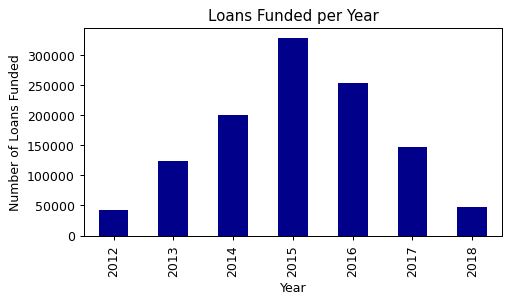

In [25]:
plt.figure(figsize=(6,3), dpi=90)
df['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [26]:
df_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.9)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

In [27]:
print('Number of loans in the partition:   ', df_train.shape[0] + df_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

Number of loans in the partition:    1142240
Number of loans in the full dataset: 1142240


In [28]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App
328576,3000.0,36,7.34,93.10,4,52000.0,2018-03-01,Fully Paid,0.58,1998,...,True,False,False,False,False,False,False,False,True,False
328577,5000.0,36,11.98,166.03,10,55000.0,2018-03-01,Fully Paid,14.18,2001,...,False,False,False,True,False,False,False,False,True,False
328578,7000.0,36,11.98,232.44,10,40000.0,2018-03-01,Fully Paid,20.25,2007,...,False,False,False,False,False,False,False,False,True,False
328579,30000.0,36,21.85,1143.39,20,57000.0,2018-03-01,Fully Paid,27.58,2000,...,False,False,False,False,False,False,False,False,True,False
328580,21000.0,60,20.39,560.94,19,85000.0,2018-03-01,Fully Paid,15.76,2008,...,False,False,False,False,False,False,False,False,True,False


### Random Forest Model

In [29]:
# Encode 'loan_status'
le = LabelEncoder()
df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_14344\1542006363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_14344\1542006363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])


In [30]:
X_train = df_train.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_train = df_train['loan_status_encoded']
X_test = df_test.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_test = df_test['loan_status_encoded']

rf_baseline = RandomForestClassifier(random_state=42)

rf_baseline.fit(X_train, y_train)

y_pred_baseline = rf_baseline.predict(X_test)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {accuracy_baseline}")

Baseline Accuracy: 0.803245547794349


In [31]:
# Get feature importance using RandomForest

importances = rf_baseline.feature_importances_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to view the importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame to see the most important features at the top
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the feature importance
print(feature_importance_df)


                                feature  importance
6                                   dti    0.091738
10                            revol_bal    0.088016
11                           revol_util    0.085012
2                              int_rate    0.082833
3                           installment    0.078899
5                            annual_inc    0.077414
12                            total_acc    0.068078
7                      earliest_cr_line    0.064169
0                             loan_amnt    0.061982
4                             sub_grade    0.059462
8                              open_acc    0.056140
14                             fico_avg    0.052866
13                             mort_acc    0.026116
1                         term (months)    0.016796
9                               pub_rec    0.011257
24           purpose_debt_consolidation    0.010248
20  verification_status_Source Verified    0.008229
23                  purpose_credit_card    0.008141
21         v

In [28]:
# Define a grid of parameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Tuned Model Accuracy: {accuracy_best}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
